# Aplicando Python para análisis de precios: simulación de escenarios futuros de precios

<img src="https://upload.wikimedia.org/wikipedia/commons/d/d7/Philippine-stock-market-board.jpg" width="400px" height="125px" />

> En la clase anterior vimos como importar datos de activos de la base de datos de Yahoo Finance usando el paquete pandas-datareader. En esta clase, veremos como pronosticar escenarios de evolución de precios, suponiendo que los rendimientos diarios se distribuyen normalmente. Como esta evolución de precios es aleatoria, utilizaremos la simulación montecarlo (hacer muchas simulaciones de escenarios de evolución de precios) para obtener probabilidades de que los precios de cierre estén encima de un valor umbral y tomar decisiones con base en estas probabilidades.

**Referencias:**
- http://pandas.pydata.org/
- http://www.learndatasci.com/python-finance-part-yahoo-finance-api-pandas-matplotlib/

## 1. Recordemos como descargar datos...

Antes que nada, para poder hacer simular escenarios de predicción de precios, vamos a recordar lo que hicimos en la clase pasada de descargar los datos de Yahoo Finance, utilizando el paquete `data` de la librería `pandas_datareader`.

Esta vez, utilizaremos los datos de precios de cierre ajustados de activos de la compañía Apple en el año 2016 para nuestra aplicación.

In [1]:
# Importamos librerías
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Función para descargar precios de cierre ajustados de varios activos a la vez:
def get_closes(names,start,end):
    closes=web.DataReader(name=names,
                          data_source='yahoo',
                          start=start,
                          end=end)
    return closes['Adj Close']

In [3]:
# Descargamos datos...
# Instrumento: Microsoft Corporation
names="MSFT"
# Fechas de interés (inicio y fin): 2013-2017
start , end = "2013-01-01", "2017-12-31"
# Función DataReader
closes = get_closes(names,start,end)
closes

Date
2013-01-02    23.671640
2013-01-03    23.354528
2013-01-04    22.917435
2013-01-07    22.874584
2013-01-08    22.754597
2013-01-09    22.883150
2013-01-10    22.677464
2013-01-11    22.994570
2013-01-14    23.045994
2013-01-15    23.320250
2013-01-16    23.174547
2013-01-17    23.354528
2013-01-18    23.354528
2013-01-22    23.268826
2013-01-23    23.663065
2013-01-24    23.680204
2013-01-25    23.894468
2013-01-28    23.920183
2013-01-29    24.005886
2013-01-30    23.868757
2013-01-31    23.525938
2013-02-01    23.937323
2013-02-04    23.517366
2013-02-05    23.568794
2013-02-06    23.431660
2013-02-07    23.380239
2013-02-08    23.611647
2013-02-11    23.877331
2013-02-12    23.894468
2013-02-13    24.023027
                ...    
2017-11-16    81.436417
2017-11-17    80.653381
2017-11-20    80.780617
2017-11-21    81.945396
2017-11-22    81.348335
2017-11-24    81.495148
2017-11-27    82.092224
2017-11-28    83.080803
2017-11-29    81.573456
2017-11-30    82.385864
2017-12-01 

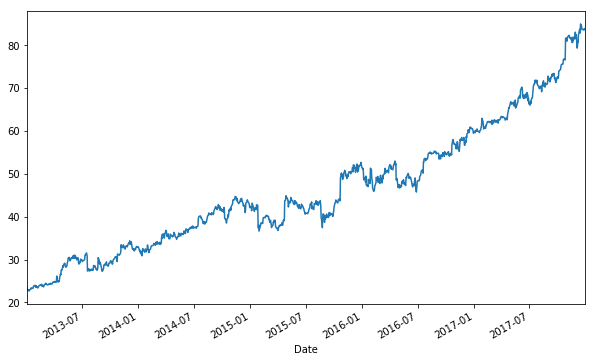

In [4]:
# Graficamos
closes.plot(figsize=(10,6));

## 2. Simulación de rendimientos diarios

Recordemos que los precios diarios de cierre ajustados no son un proceso estocástico estacionario, pero los rendimientos diarios si lo son. Por tanto calculamos los rendimientos a partir de los precios de cierre, obtenemos sus propiedades estadísticas muestrales y proyectamos los rendimientos. Luego, obtenemos la proyección de los precios.

Para una sucesión de precios $\{S_t\}_{t=0}^{n}$, el rendimiento simple $R_t$ se define como el el cambio porcentual

$$
R_t=\frac{S_t-S_{t-1}}{S_{t-1}}\approx \ln\left(\frac{S_t}{S_{t-1}}\right)=r_t.
$$
para $t=1,\ldots,n$.

Para el ejemplo en curso, ¿cómo calcular esto?

Además, supusimos que los rendimientos diarios eran una variable aleatoria con distribución normal (que se caracteriza con su media y varianza). Por tanto obtenemos la media y desviación estandar muestrales. Hagamos una función que retorne lo anterior.

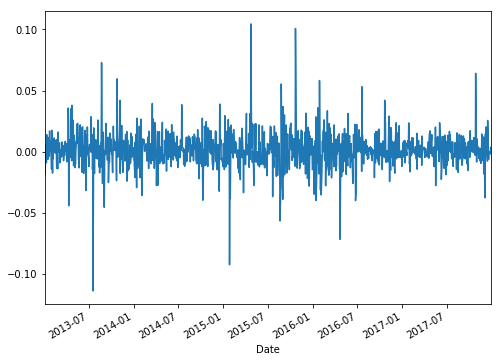

In [6]:
# Calcular rendimientos diarios y graficarlos
ret = closes.pct_change().dropna()
ret.plot(figsize=(8,6))

Entonces, suponemos que la diferencia logaritmica de los precios (rendimientos diarios) tiene una distribución normal.

¿Cómo se caracteriza una [distribución normal](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_normal)?

In [7]:
# Calculamos media y desviación estándar
mu, std = ret.mean(), ret.std()
mu , std

(0.0011037456554284992, 0.014082222284962939)

Habiendo caracterizado los rendimientos diarios como una variable aleatoria normal con la media y la varianza muestral obtenida de los datos del 2016, podemos generar números aleatorios con estas características para simular el comportamiento de los precios de cierre de las acciones en el 2017 (hay un supuesto de que las cosas no cambiarán fundamentalmente).

Sin embargo, cada simulación que hagamos nos conducirá a distintos resultados (los precios siguen evolucionando aleatoriamente). Entonces, lo que haremos es simular varios escenarios para así ver alguna tendencia y tomar decisiones.

Hagamos una una función que simule varios escenarios de rendimientos diarios rendimientos diarios y que devuelva un dataframe con esta simulación.

In [8]:
# Ayuda en la función np.random.randn
help(np.random.randn)

Help on built-in function randn:

randn(...) method of mtrand.RandomState instance
    randn(d0, d1, ..., dn)
    
    Return a sample (or samples) from the "standard normal" distribution.
    
    If positive, int_like or int-convertible arguments are provided,
    `randn` generates an array of shape ``(d0, d1, ..., dn)``, filled
    with random floats sampled from a univariate "normal" (Gaussian)
    distribution of mean 0 and variance 1 (if any of the :math:`d_i` are
    floats, they are first converted to integers by truncation). A single
    float randomly sampled from the distribution is returned if no
    argument is provided.
    
    This is a convenience function.  If you want an interface that takes a
    tuple as the first argument, use `numpy.random.standard_normal` instead.
    
    Parameters
    ----------
    d0, d1, ..., dn : int, optional
        The dimensions of the returned array, should be all positive.
        If no argument is given a single Python float is ret

In [9]:
# Función que simula varios escenarios de rendimientos diarios
def ret_sim(mu,std,ndays,nscen,start_date):
    dates = pd.date_range(start=start_date, periods=ndays)
    return pd.DataFrame(data= std*np.random.randn(ndays,nscen)+mu, index= dates)

In [10]:
# Simulamos 100 escenarios para todo el 2018
ndays = 260
nscen = 1000
start_date= '2018-01-01'

simret=ret_sim(mu,std,ndays,nscen,start_date)

In [11]:
# Mostrar
simret

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2018-01-01,-0.029157,-0.027154,0.027439,-0.024265,0.005866,-0.016654,0.002863,-0.023079,-0.018030,-0.005587,...,0.022689,0.025835,-0.001385,0.008895,-0.004161,0.007564,-0.015393,0.040774,0.007900,0.006230
2018-01-02,0.010654,0.017060,0.003091,0.010922,-0.010021,-0.026495,-0.005584,0.006273,0.014042,-0.021508,...,-0.005228,-0.032650,-0.010530,-0.000440,0.015335,0.005426,-0.010650,-0.020007,0.003396,0.011605
2018-01-03,0.021872,-0.000171,-0.013471,-0.007942,-0.021100,-0.007347,0.010145,0.038936,-0.006185,0.013638,...,-0.000018,0.003268,0.003093,-0.005654,-0.017146,-0.011408,0.001620,0.007722,0.021706,0.000922
2018-01-04,0.009167,-0.002933,-0.006929,0.010533,0.004339,0.006701,-0.025503,-0.003944,0.003098,0.012142,...,0.001391,0.007726,-0.001559,0.006403,0.020129,-0.003179,0.007988,0.014476,0.004939,-0.013671
2018-01-05,0.013447,-0.006544,-0.004457,-0.009584,0.018539,0.008119,-0.011065,-0.008533,0.000829,0.024164,...,0.001261,-0.007517,-0.013480,0.018070,-0.009921,-0.008734,0.018654,0.019836,-0.011540,0.030157
2018-01-06,0.006234,-0.003111,0.007890,-0.012336,0.015152,0.020390,0.001345,0.006980,-0.001750,-0.020210,...,-0.002766,0.001127,0.001864,0.010014,-0.014009,-0.005510,-0.014058,-0.000703,-0.023288,0.001122
2018-01-07,-0.003702,0.019783,0.009827,-0.011714,0.007362,-0.002086,-0.014333,-0.012767,0.001873,-0.012000,...,-0.007015,-0.004635,0.007288,-0.000213,0.002074,0.016960,0.002165,-0.005197,-0.002538,0.015079
2018-01-08,0.000182,0.001809,0.026473,-0.011676,-0.021202,0.010182,-0.017500,-0.006002,-0.012705,-0.008914,...,0.007177,0.010163,0.026858,0.007493,-0.005052,0.017597,-0.008168,-0.025431,0.006812,-0.015704
2018-01-09,0.004123,0.055338,0.016306,0.003473,0.021278,0.022353,0.002751,-0.009711,-0.024635,-0.008105,...,0.007402,-0.028747,-0.004359,-0.004862,0.012273,0.006497,0.004955,-0.010887,0.022794,-0.006361
2018-01-10,-0.009748,0.000306,0.018116,-0.001528,-0.004200,-0.003432,-0.030209,0.027764,-0.014458,0.014679,...,0.016935,0.003056,0.006680,0.000941,0.027134,-0.002538,0.003372,0.013668,-0.007496,0.035139


## 3. Proyección de precios de cierre

Por tanto, para calcular los precios, tenemos:

$$\begin{align}
p_i&=p_{i-1}(R_i+1)\\
p_{i+1}&=p_i(R_{i+1}+1)=p_{i-1}(R_i+1)(R_{i+1}+1)\\
&\vdots\\
p_{i+k}&=p_{i-1}(R_i+1)\cdots(R_{i+k}+1).
\end{align}$$

Si hacemos $i=0$ en la última ecuación, tenemos que $p_{k}=p_{-1}(R_0+1)\cdots(R_{k}+1)$, donde $p_{-1}$ es el último precio reportado en el 2017.

Con los rendimientos, calculamos los precios de cierre...

In [12]:
# Obtenemos los precios
simcloses= closes.iloc[-1]*((1+simret).cumprod())
simcloses

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2018-01-01,81.285621,81.453273,86.024184,81.695171,84.217949,82.332387,83.966530,81.794476,82.217203,83.259055,...,85.626456,85.889898,83.610894,84.471574,83.378385,84.360154,82.437973,87.140692,84.388263,84.248418
2018-01-02,82.151630,82.842852,86.290042,82.587422,83.374013,80.151019,83.497639,82.307594,83.371694,81.468331,...,85.178791,83.085554,82.730432,84.434427,84.656988,84.817884,81.560012,85.397252,84.674880,85.226088
2018-01-03,83.948434,82.828714,85.127639,81.931486,81.614818,79.562159,84.344721,85.512333,82.856078,82.579355,...,85.177239,83.357080,82.986357,83.956995,83.205474,83.850279,81.692101,86.056723,86.512840,85.304662
2018-01-04,84.717984,82.585813,84.537817,82.794508,81.968964,80.095269,82.193712,85.175101,83.112757,83.582047,...,85.295716,84.001125,82.857009,84.494545,84.880323,83.583690,82.344631,87.302492,86.940134,84.138443
2018-01-05,85.857167,82.045365,84.161067,82.001007,83.488581,80.745585,81.284215,84.448329,83.181656,85.601763,...,85.403297,83.369699,81.740057,86.021334,84.038193,82.853665,83.880701,89.034233,85.936809,86.675814
2018-01-06,86.392420,81.790111,84.825066,80.989460,84.753625,82.391988,81.393537,85.037796,83.036050,83.871757,...,85.167056,83.463631,81.892400,86.882778,82.860885,82.397103,82.701513,88.971615,83.935512,86.773045
2018-01-07,86.072553,83.408192,85.658637,80.040735,85.377578,82.220114,80.226957,83.952150,83.191611,82.865261,...,84.569619,83.076795,82.489196,86.864315,83.032731,83.794537,82.880550,88.509192,83.722521,88.081483
2018-01-08,86.088228,83.559107,87.926312,79.106191,83.567429,83.057295,78.822988,83.448278,82.134689,82.126575,...,85.176577,83.921095,84.704731,87.515225,82.613267,85.269068,82.203563,86.258336,84.292809,86.698228
2018-01-09,86.443163,88.183103,89.360063,79.380950,85.345552,84.913835,79.039810,82.637940,80.111289,81.460930,...,85.807075,81.508649,84.335509,87.089717,83.627190,85.823056,82.610887,85.319232,86.214185,86.146779
2018-01-10,85.600556,88.210109,90.978892,79.259671,84.987132,84.622419,76.652109,84.932309,78.953009,82.656703,...,87.260237,81.757745,84.898840,87.171668,85.896293,85.605234,82.889440,86.485401,85.567910,89.173860


Graficamos...

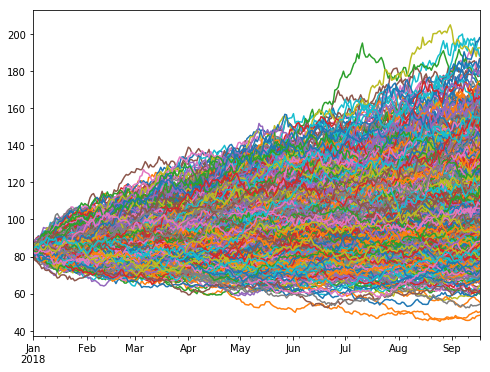

In [13]:
# Graficar
simcloses.plot(figsize=(8,6),legend=False)

## 4. Probabilidad Precio-Umbral

Ya que tenemos muchos escenarios de precios proyectados, podemos ver varias cosas. Por ejemplo, ¿cuál es la probabilidad de que el precio de cierre sobrepase algún valor umbral en algún momento?

In [14]:
# Umbral de 110% del ultimo precio
K= closes.iloc[-1]*1.1
K

92.0994956970215

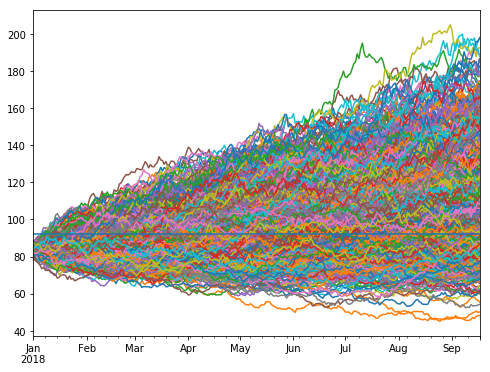

In [15]:
# Fechas
dates = simcloses.index
# DataFrame de Umbrales
Umbrales= pd.DataFrame(index=dates, columns=['K'], data = K*np.ones(len(dates)))
# Concatenar y graficar
simcloses_K= pd.concat([simcloses.T,Umbrales.T]).T
simcloses_K.plot(figsize=(8,6),legend=False);

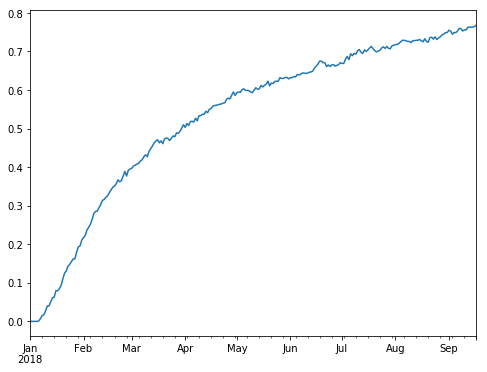

In [16]:
# Comparar cada escenario en cada fecha
Comp= simcloses>K
# Sumamos para cada fecha y dividimos entre el número de escenarios
prob=pd.DataFrame(Comp.sum(axis=1)/nscen)
# Gráfico de probabilidad
prob.plot(figsize=(8,6),legend=False)

___
Entonces, ya aprendimos a bajar datos con pandas-datareader. En específico, a partir de los precios de cierre ajustados obtuvimos los rendimientos diarios.

Suponiendo que los rendimientos diarios son un proceso estocástico estacionario de distribución normal, pudimos caracaterizarlo y proyectar varios escenarios de evolución de los precios (montecarlo).

Con estas proyecciones pudimos calcular probabilidades de sobrepasar cierto precio umbral: toma de decisiones.